# Test 6D Pose Estimation con PoseEstimator

Questo notebook permette di:
1. **Carica dataset LineMOD** con split ufficiale train/test
2. **Inizializza PoseEstimator** (ResNet-50 backbone + regression head)
3. **Training**
4. **Valutazione con ADD metric** sul test set

### Sezione da Eseguire sempre
Esegui sempre questa sezione per configurare l'ambiente. Poi scegli:
- **Training completo**
- **Test modello già trainato**

In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from tqdm import tqdm

# Configura matplotlib per notebook
%matplotlib inline

# Aggiungi il path del progetto
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from dataset.custom_dataset import create_pose_dataloaders
from models.pose_estimator import PoseEstimator
from utils.losses import PoseLoss
from utils.metrics import load_all_models, load_models_info, compute_add_batch
from utils.transforms import quaternion_to_rotation_matrix
from config import Config

print(f"✅ Setup completato")
print(f"📂 Project root: {project_root}")
print(f"🎯 Dataset: LineMOD")
print(f"🖥️  Device: {Config.DEVICE}")
print(f"📊 Image size: {Config.POSE_IMAGE_SIZE}x{Config.POSE_IMAGE_SIZE}")
print(f"🔢 Batch size: {Config.POSE_BATCH_SIZE}")

✅ Setup completato
📂 Project root: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation
🎯 Dataset: LineMOD
🖥️  Device: mps
📊 Image size: 224x224
🔢 Batch size: 64


In [2]:
# Carica dataset con split ufficiale train/test
print("📦 Caricamento PoseDataset con split ufficiale...\n")

train_loader, test_loader = create_pose_dataloaders(
    dataset_root=Config.DATA_ROOT,
    batch_size=Config.POSE_BATCH_SIZE,
    crop_margin=Config.POSE_CROP_MARGIN,
    output_size=Config.POSE_IMAGE_SIZE,
    num_workers=Config.NUM_WORKERS_POSE  # Adaptive: 0 on MPS, optimal on CUDA/CPU
)

print(f"✅ Dataset caricato:")
print(f"   Train batches: {len(train_loader)} (batch_size={Config.POSE_BATCH_SIZE})")
print(f"   Test batches: {len(test_loader)}")
print(f"   Train samples: ~{len(train_loader) * Config.POSE_BATCH_SIZE}")
print(f"   Test samples: ~{len(test_loader) * Config.POSE_BATCH_SIZE}")
print(f"   Crop margin: {Config.POSE_CROP_MARGIN * 100:.0f}%")
print(f"   Output size: {Config.POSE_IMAGE_SIZE}x{Config.POSE_IMAGE_SIZE}")
print(f"   Workers: {Config.NUM_WORKERS_POSE} (adaptive per {Config.DEVICE})")

📦 Caricamento PoseDataset con split ufficiale...

🔄 Preloading metadata for 13 folders...
✅ PoseDataset initialized: 3759 train samples
🚀 Cached 13 gt.yml and 13 info.yml files
🔄 Preloading metadata for 13 folders...
✅ PoseDataset initialized: 21218 test samples
🚀 Cached 13 gt.yml and 13 info.yml files

📊 Pose DataLoaders created:
   Training samples: 3759
   Training batches: 59
   Test samples: 21218
   Test batches: 332
✅ Dataset caricato:
   Train batches: 59 (batch_size=64)
   Test batches: 332
   Train samples: ~3776
   Test samples: ~21248
   Crop margin: 15%
   Output size: 224x224
   Workers: 0 (adaptive per mps)


In [3]:
# # Visualizza alcuni sample del dataset
# print("\n🖼️  Visualizzazione sample del training set\n")

# # Prendi un batch
# batch = next(iter(train_loader))
# images = batch['rgb_crop']  # [B, 3, 224, 224]
# quaternions = batch['quaternion']  # [B, 4]
# translations = batch['translation']  # [B, 3]
# obj_ids = batch['obj_id']  # [B]

# # Visualizza 4 sample
# fig, axes = plt.subplots(2, 2, figsize=(12, 12))
# axes = axes.flatten()

# for i in range(min(4, len(images))):
#     # Denormalizza immagine (ImageNet normalization)
#     img = images[i].permute(1, 2, 0).cpu().numpy()
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     img = img * std + mean
#     img = np.clip(img, 0, 1)
    
#     # Ground truth
#     quat = quaternions[i].cpu().numpy()
#     trans = translations[i].cpu().numpy()
#     obj_id = obj_ids[i].item()
    
#     axes[i].imshow(img)
#     axes[i].set_title(
#         f"Object {obj_id:02d}\n"
#         f"Quat: [{quat[0]:.2f}, {quat[1]:.2f}, {quat[2]:.2f}, {quat[3]:.2f}]\n"
#         f"Trans: [{trans[0]:.1f}, {trans[1]:.1f}, {trans[2]:.1f}] mm",
#         fontsize=10
#     )
#     axes[i].axis('off')

# plt.tight_layout()
# plt.show()

# print(f"✅ Visualizzazione completata!")
# print(f"   Crop centrato sul bbox con {Config.POSE_CROP_MARGIN * 100:.0f}% margin")
# print(f"   Quaternion normalizzato (||q|| = 1)")
# print(f"   Translation in millimetri (mm)")

### Inizializza Modello PoseEstimator

ResNet-50 backbone (pretrained ImageNet) + regression head (Linear 2048→1024→512→7).
Output: 4D quaternion [qw, qx, qy, qz] + 3D translation [tx, ty, tz]

In [4]:
# Inizializza PoseEstimator con backbone SBLOCCATO (Fase 1 ottimizzazione)
print("🤖 Inizializzazione PoseEstimator...\n")

model = PoseEstimator(
    pretrained=True,
    dropout=Config.POSE_DROPOUT,
    freeze_backbone=False  # ✅ SBLOCCATO per fine-tuning completo
).to(Config.DEVICE)

print(f"✅ Modello inizializzato:")
print(f"   Backbone: ResNet-50 (pretrained ImageNet)")
print(f"   Dropout: {Config.POSE_DROPOUT}")
print(f"   Output: 4D quaternion + 3D translation")

# Conta parametri
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Parametri del modello:")
print(f"   Parametri totali: {total_params:,}")
print(f"   Parametri trainable: {trainable_params:,}")
print(f"   Percentuale trainable: {100 * trainable_params / total_params:.1f}%")

print(f"\n💡 Modalità: Backbone SBLOCCATO (Fase 1)")
print(f"   Tutti i parametri trainable (~25M)")
print(f"   Fine-tuning completo ResNet-50 + regression head")
print(f"   Training più lento ma risultati migliori")

🤖 Inizializzazione PoseEstimator...



/Users/nicolotermine/Library/Caches/pypoetry/virtualenvs/polito-aml-6d-pose-estimation-LevBIKLF-py3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nicolotermine/Library/Caches/pypoetry/virtualenvs/polito-aml-6d-pose-estimation-LevBIKLF-py3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ PoseEstimator initialized
   Backbone: ResNet-50 (pretrained=True, frozen=False)
   Feature dim: 2048
   Output: 7 values (4 quaternion + 3 translation)
   Dropout: 0.5
✅ Modello inizializzato:
   Backbone: ResNet-50 (pretrained ImageNet)
   Dropout: 0.5
   Output: 4D quaternion + 3D translation

📊 Parametri del modello:
   Parametri totali: 26,137,671
   Parametri trainable: 26,137,671
   Percentuale trainable: 100.0%

💡 Modalità: Backbone SBLOCCATO (Fase 1)
   Tutti i parametri trainable (~25M)
   Fine-tuning completo ResNet-50 + regression head
   Training più lento ma risultati migliori


### Training

Training rapido per testare il pipeline. Per risultati migliori, usa 50 epoche con backbone unfrozen.

In [5]:
# ⚡ FASE 1: TRAINING OTTIMIZZATO
# - Backbone sbloccato
# - Learning rate differenziato
# - Warmup + ReduceLROnPlateau

EPOCHS = Config.POSE_EPOCHS  # ✅ Ridotto: backbone unfrozen converge più velocemente
WARMUP_EPOCHS = 5  # ✅ Warmup graduale per stabilizzare training
EXPERIMENT_NAME = "pose_stable_train100"

# Learning rates differenziati
LR_BACKBONE = 5e-6  # da 1e-5 a 5e-6 (più conservativo)
LR_HEAD = 1e-4      # Standard per regression head

# Gradient Accumulation
ACCUMULATION_STEPS = Config.ACCUMULATION_STEPS
EFFECTIVE_BATCH_SIZE = Config.POSE_BATCH_SIZE * ACCUMULATION_STEPS

print(f"⚡ FASE 1 - Training Ottimizzato:")
print(f"   Esperimento: {EXPERIMENT_NAME}")
print(f"   Epoche: {EPOCHS} (+ {WARMUP_EPOCHS} warmup)")
print(f"   Batches per epoca: {len(train_loader)}")
print(f"   🚀 LR Backbone: {LR_BACKBONE:.2e} (fine-tuning delicato)")
print(f"   🚀 LR Head: {LR_HEAD:.2e} (standard)")
print(f"   🚀 Batch size: {Config.POSE_BATCH_SIZE}")
print(f"   🚀 Accumulation steps: {ACCUMULATION_STEPS}")
print(f"   🚀 Effective batch size: {EFFECTIVE_BATCH_SIZE}")
print(f"   Lambda translation: {Config.LAMBDA_TRANS}")
print(f"   Lambda rotation: {Config.LAMBDA_ROT}")
print(f"   Device: {Config.DEVICE}")

# AMP per CUDA
use_amp = Config.DEVICE == 'cuda' and hasattr(torch.cuda, 'amp')
if use_amp:
    print(f"   🚀 AMP enabled (FP16 training)")
    scaler = torch.amp.GradScaler()
else:
    print(f"   ⚠️  AMP disabled (device={Config.DEVICE})")
    scaler = None

print(f"\n💡 Miglioramenti Fase 1:")
print(f"   ✓ Backbone sbloccato: fine-tuning completo (~25M params)")
print(f"   ✓ Learning rate differenziato: backbone 10x più basso")
print(f"   ✓ Warmup: {WARMUP_EPOCHS} epoche per stabilizzare")
print(f"   ✓ ReduceLROnPlateau: LR si riduce solo se loss stagna")
print(f"   ✓ Gradient Accumulation: effective batch {EFFECTIVE_BATCH_SIZE}")

# Setup training con learning rate differenziato
criterion = PoseLoss(
    lambda_trans=Config.LAMBDA_TRANS,
    lambda_rot=Config.LAMBDA_ROT
)

# ✅ OTTIMIZZAZIONE: Learning rate differenziato per backbone e head
optimizer = torch.optim.AdamW([
    {'params': model.backbone.parameters(), 'lr': LR_BACKBONE, 'name': 'backbone'},
    {'params': model.pose_head.parameters(), 'lr': LR_HEAD, 'name': 'head'}
], weight_decay=Config.POSE_WEIGHT_DECAY)

# ✅ OTTIMIZZAZIONE: ReduceLROnPlateau invece di CosineAnnealing
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,      # Riduce LR di 50% quando stagna
    patience=5,      # Attende 5 epoche prima di ridurre
    min_lr=1e-7      # LR minimo
)

# Crea struttura cartelle
checkpoint_dir = project_root / 'checkpoints' / 'pose' / EXPERIMENT_NAME
checkpoint_dir.mkdir(parents=True, exist_ok=True)

weights_dir = checkpoint_dir / 'weights'
weights_dir.mkdir(exist_ok=True)

# Salva configurazione
config_file = checkpoint_dir / 'args.yaml'
import yaml
training_config = {
    'phase': 'Phase 1 - Optimized',
    'epochs': EPOCHS,
    'warmup_epochs': WARMUP_EPOCHS,
    'lr_backbone': float(LR_BACKBONE),
    'lr_head': float(LR_HEAD),
    'batch_size': Config.POSE_BATCH_SIZE,
    'accumulation_steps': ACCUMULATION_STEPS,
    'effective_batch_size': EFFECTIVE_BATCH_SIZE,
    'use_amp': use_amp,
    'lambda_trans': Config.LAMBDA_TRANS,
    'lambda_rot': Config.LAMBDA_ROT,
    'dropout': Config.POSE_DROPOUT,
    'freeze_backbone': False,
    'scheduler': 'ReduceLROnPlateau',
    'device': str(Config.DEVICE),
    'image_size': Config.POSE_IMAGE_SIZE,
    'crop_margin': Config.POSE_CROP_MARGIN,
}
with open(config_file, 'w') as f:
    yaml.dump(training_config, f, default_flow_style=False)

print(f"\n📁 Checkpoint directory: {checkpoint_dir}")
print(f"   ├── args.yaml")
print(f"   ├── results.csv")
print(f"   └── weights/")
print(f"       ├── best.pt")
print(f"       └── last.pt\n")

# Training loop con warmup
history = {'train_loss': [], 'train_trans': [], 'train_rot': [], 'lr_backbone': [], 'lr_head': []}
best_loss = float('inf')
best_epoch = 0

results_file = checkpoint_dir / 'results.csv'
with open(results_file, 'w') as f:
    f.write('epoch,train_loss,train_trans_loss,train_rot_loss,lr_backbone,lr_head\n')

for epoch in range(EPOCHS):
    # ✅ WARMUP: Aumenta gradualmente LR nelle prime WARMUP_EPOCHS
    if epoch < WARMUP_EPOCHS:
        warmup_factor = (epoch + 1) / WARMUP_EPOCHS
        for param_group in optimizer.param_groups:
            if param_group['name'] == 'backbone':
                param_group['lr'] = LR_BACKBONE * warmup_factor
            else:  # head
                param_group['lr'] = LR_HEAD * warmup_factor
        print(f"🔥 Warmup epoch {epoch+1}/{WARMUP_EPOCHS} - LR scale: {warmup_factor:.2f}")
    
    model.train()
    epoch_loss = 0
    epoch_trans = 0
    epoch_rot = 0
    
    optimizer.zero_grad()
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}')
    for batch_idx, batch in enumerate(pbar):
        # Move to device
        images = batch['rgb_crop'].to(Config.DEVICE)
        gt_quaternion = batch['quaternion'].to(Config.DEVICE)
        gt_translation = batch['translation'].to(Config.DEVICE)
        
        # Forward pass with AMP (if enabled)
        if use_amp:
            with torch.cuda.amp.autocast():
                pred_quaternion, pred_translation = model(images)
                loss_dict = criterion(
                    pred_quaternion, pred_translation,
                    gt_quaternion, gt_translation
                )
                loss = loss_dict['total'] / ACCUMULATION_STEPS
        else:
            pred_quaternion, pred_translation = model(images)
            loss_dict = criterion(
                pred_quaternion, pred_translation,
                gt_quaternion, gt_translation
            )
            loss = loss_dict['total'] / ACCUMULATION_STEPS
        
        # Backward pass
        if use_amp:
            scaler.scale(loss).backward()
        else:
            loss.backward()
        
        # Update weights every ACCUMULATION_STEPS
        if (batch_idx + 1) % ACCUMULATION_STEPS == 0 or (batch_idx + 1) == len(train_loader):
            if use_amp:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
        
        # Update metrics
        epoch_loss += loss_dict['total'].item()
        epoch_trans += loss_dict['trans'].item()
        epoch_rot += loss_dict['rot'].item()
        
        # Update progress bar
        current_lr_backbone = optimizer.param_groups[0]['lr']
        current_lr_head = optimizer.param_groups[1]['lr']
        pbar.set_postfix({
            'loss': f"{loss_dict['total'].item():.4f}",
            'trans': f"{loss_dict['trans'].item():.4f}",
            'rot': f"{loss_dict['rot'].item():.2f}",
            'lr_bb': f"{current_lr_backbone:.2e}",
            'lr_hd': f"{current_lr_head:.2e}"
        })
    
    # Epoch statistics
    num_batches = len(train_loader)
    avg_loss = epoch_loss / num_batches
    avg_trans = epoch_trans / num_batches
    avg_rot = epoch_rot / num_batches
    
    current_lr_backbone = optimizer.param_groups[0]['lr']
    current_lr_head = optimizer.param_groups[1]['lr']
    
    history['train_loss'].append(avg_loss)
    history['train_trans'].append(avg_trans)
    history['train_rot'].append(avg_rot)
    history['lr_backbone'].append(current_lr_backbone)
    history['lr_head'].append(current_lr_head)
    
    # Salva risultati epoch
    with open(results_file, 'a') as f:
        f.write(f"{epoch+1},{avg_loss:.6f},{avg_trans:.6f},{avg_rot:.6f},{current_lr_backbone:.8e},{current_lr_head:.8e}\n")
    
    print(f"\n📊 Epoch {epoch+1}/{EPOCHS} Summary:")
    print(f"   Loss: {avg_loss:.4f} | Trans: {avg_trans:.4f} | Rot: {avg_rot:.2f}")
    print(f"   LR Backbone: {current_lr_backbone:.2e} | LR Head: {current_lr_head:.2e}")
    
    # ✅ SCHEDULER: Riduci LR se loss stagna (dopo warmup)
    if epoch >= WARMUP_EPOCHS:
        scheduler.step(avg_loss)
    
    # Save best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_epoch = epoch
        best_path = weights_dir / 'best.pt'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
            'loss_trans': avg_trans,
            'loss_rot': avg_rot,
            'config': training_config,
        }, best_path)
        print(f"   💾 Best model salvato: {best_path.relative_to(project_root)}")
    
    # Save last model
    last_path = weights_dir / 'last.pt'
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_loss,
        'loss_trans': avg_trans,
        'loss_rot': avg_rot,
        'config': training_config,
    }, last_path)
    
    # ✅ EARLY STOPPING: Ferma se non migliora per 10 epoche
    if epoch - best_epoch >= 10 and epoch >= WARMUP_EPOCHS:
        print(f"\n⚠️  Early stopping! Loss non migliora da {epoch - best_epoch} epoche")
        print(f"   Best loss: {best_loss:.4f} @ epoch {best_epoch + 1}")
        break
    
    print()

print(f"✅ Training Fase 1 completato!")
print(f"   Best loss: {best_loss:.4f} @ epoch {best_epoch + 1}")
print(f"   Modelli salvati in: {checkpoint_dir.relative_to(project_root)}")
print(f"   📁 Struttura:")
print(f"      ├── args.yaml")
print(f"      ├── results.csv")
print(f"      └── weights/")
print(f"          ├── best.pt (best loss: {best_loss:.4f})")
print(f"          └── last.pt (last epoch)")

print(f"\n🚀 Ottimizzazioni Fase 1:")
print(f"   • Backbone sbloccato: fine-tuning completo")
print(f"   • Learning rate differenziato: {LR_BACKBONE:.2e} (bb) / {LR_HEAD:.2e} (head)")
print(f"   • Warmup: {WARMUP_EPOCHS} epoche")
print(f"   • ReduceLROnPlateau: adattivo")
print(f"   • Early stopping: patience 10 epoche")
print(f"   • Gradient Accumulation: {ACCUMULATION_STEPS}x")

# Aggiorna variabile globale per celle successive
checkpoint_path = weights_dir / 'best.pt'

⚡ FASE 1 - Training Ottimizzato:
   Esperimento: pose_stable_train100
   Epoche: 100 (+ 5 warmup)
   Batches per epoca: 59
   🚀 LR Backbone: 5.00e-06 (fine-tuning delicato)
   🚀 LR Head: 1.00e-04 (standard)
   Batch size: 64
   🚀 Accumulation steps: 2
   🚀 Effective batch size: 128
   Lambda translation: 1.0
   Lambda rotation: 50.0
   Device: mps
   ⚠️  AMP disabled (device=mps)

💡 Miglioramenti Fase 1:
   ✓ Backbone sbloccato: fine-tuning completo (~25M params)
   ✓ Learning rate differenziato: backbone 10x più basso
   ✓ Warmup: 5 epoche per stabilizzare
   ✓ ReduceLROnPlateau: LR si riduce solo se loss stagna
   ✓ Gradient Accumulation: effective batch 128
✅ PoseLoss initialized
   λ_trans: 1.0
   λ_rot: 50.0

📁 Checkpoint directory: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_stable_train100
   ├── args.yaml
   ├── results.csv
   └── weights/
       ├── best.pt
       └── last.pt

🔥 Warmup epoch 1/5 - LR scale: 0.20


Epoch 1/100:   8%|▊         | 5/59 [00:06<01:02,  1.16s/it, loss=294.2505, trans=236.4674, rot=1.16, lr_bb=1.00e-06, lr_hd=2.00e-05]

Epoch 1/100: 100%|██████████| 59/59 [01:05<00:00,  1.10s/it, loss=254.9301, trans=201.9486, rot=1.06, lr_bb=1.00e-06, lr_hd=2.00e-05]



📊 Epoch 1/100 Summary:
   Loss: 267.9973 | Trans: 214.7045 | Rot: 1.07
   LR Backbone: 1.00e-06 | LR Head: 2.00e-05
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt

🔥 Warmup epoch 2/5 - LR scale: 0.40


Epoch 2/100:  19%|█▊        | 11/59 [00:11<00:52,  1.09s/it, loss=227.4325, trans=175.4552, rot=1.04, lr_bb=2.00e-06, lr_hd=4.00e-05]

Epoch 2/100: 100%|██████████| 59/59 [01:03<00:00,  1.07s/it, loss=218.2705, trans=165.9261, rot=1.05, lr_bb=2.00e-06, lr_hd=4.00e-05]



📊 Epoch 2/100 Summary:
   Loss: 229.6447 | Trans: 176.5701 | Rot: 1.06
   LR Backbone: 2.00e-06 | LR Head: 4.00e-05
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt

🔥 Warmup epoch 3/5 - LR scale: 0.60


Epoch 3/100:  49%|████▉     | 29/59 [00:30<00:31,  1.04s/it, loss=194.9372, trans=144.0149, rot=1.02, lr_bb=3.00e-06, lr_hd=6.00e-05]

Epoch 3/100: 100%|██████████| 59/59 [01:01<00:00,  1.04s/it, loss=159.5894, trans=109.0150, rot=1.01, lr_bb=3.00e-06, lr_hd=6.00e-05]



📊 Epoch 3/100 Summary:
   Loss: 186.5686 | Trans: 135.5035 | Rot: 1.02
   LR Backbone: 3.00e-06 | LR Head: 6.00e-05
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt

🔥 Warmup epoch 4/5 - LR scale: 0.80


Epoch 4/100:  32%|███▏      | 19/59 [00:19<00:41,  1.04s/it, loss=188.1467, trans=138.9962, rot=0.98, lr_bb=4.00e-06, lr_hd=8.00e-05]

Epoch 4/100: 100%|██████████| 59/59 [01:01<00:00,  1.04s/it, loss=164.6763, trans=120.5524, rot=0.88, lr_bb=4.00e-06, lr_hd=8.00e-05]



📊 Epoch 4/100 Summary:
   Loss: 162.9231 | Trans: 114.8456 | Rot: 0.96
   LR Backbone: 4.00e-06 | LR Head: 8.00e-05
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt

🔥 Warmup epoch 5/5 - LR scale: 1.00


Epoch 5/100:  58%|█████▊    | 34/59 [00:35<00:26,  1.07s/it, loss=147.3195, trans=100.1809, rot=0.94, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 5/100: 100%|██████████| 59/59 [01:01<00:00,  1.05s/it, loss=143.1521, trans=96.7316, rot=0.93, lr_bb=5.00e-06, lr_hd=1.00e-04] 



📊 Epoch 5/100 Summary:
   Loss: 148.8270 | Trans: 104.0379 | Rot: 0.90
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 6/100:  80%|███████▉  | 47/59 [00:48<00:12,  1.02s/it, loss=134.5547, trans=88.7424, rot=0.92, lr_bb=5.00e-06, lr_hd=1.00e-04] 

Epoch 6/100: 100%|██████████| 59/59 [01:00<00:00,  1.02s/it, loss=122.4513, trans=81.4090, rot=0.82, lr_bb=5.00e-06, lr_hd=1.00e-04] 



📊 Epoch 6/100 Summary:
   Loss: 136.3690 | Trans: 93.5581 | Rot: 0.86
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 7/100:  86%|████████▋ | 51/59 [00:52<00:08,  1.02s/it, loss=116.3678, trans=76.3434, rot=0.80, lr_bb=5.00e-06, lr_hd=1.00e-04] 

Epoch 7/100: 100%|██████████| 59/59 [01:00<00:00,  1.02s/it, loss=109.8987, trans=71.1464, rot=0.78, lr_bb=5.00e-06, lr_hd=1.00e-04] 



📊 Epoch 7/100 Summary:
   Loss: 129.4846 | Trans: 87.9661 | Rot: 0.83
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 8/100:  71%|███████   | 42/59 [00:43<00:17,  1.03s/it, loss=124.1180, trans=84.4526, rot=0.79, lr_bb=5.00e-06, lr_hd=1.00e-04] 

Epoch 8/100: 100%|██████████| 59/59 [01:00<00:00,  1.02s/it, loss=130.8452, trans=87.2497, rot=0.87, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 8/100 Summary:
   Loss: 121.1052 | Trans: 80.7610 | Rot: 0.81
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 9/100:  63%|██████▎   | 37/59 [00:38<00:22,  1.02s/it, loss=104.8762, trans=67.2038, rot=0.75, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 9/100: 100%|██████████| 59/59 [01:00<00:00,  1.02s/it, loss=100.3994, trans=62.1330, rot=0.77, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 9/100 Summary:
   Loss: 115.5106 | Trans: 75.7718 | Rot: 0.79
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 10/100:  83%|████████▎ | 49/59 [00:51<00:10,  1.04s/it, loss=111.2972, trans=73.9450, rot=0.75, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 10/100: 100%|██████████| 59/59 [01:01<00:00,  1.04s/it, loss=107.7572, trans=65.8308, rot=0.84, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 10/100 Summary:
   Loss: 108.8487 | Trans: 70.0848 | Rot: 0.78
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 11/100:  15%|█▌        | 9/59 [00:09<00:52,  1.04s/it, loss=105.3153, trans=67.1152, rot=0.76, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 11/100: 100%|██████████| 59/59 [01:01<00:00,  1.04s/it, loss=92.6775, trans=57.3789, rot=0.71, lr_bb=5.00e-06, lr_hd=1.00e-04] 



📊 Epoch 11/100 Summary:
   Loss: 103.0437 | Trans: 65.1150 | Rot: 0.76
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 12/100:  25%|██▌       | 15/59 [00:15<00:45,  1.04s/it, loss=102.6714, trans=61.7003, rot=0.82, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 12/100: 100%|██████████| 59/59 [01:01<00:00,  1.04s/it, loss=93.6223, trans=58.2167, rot=0.71, lr_bb=5.00e-06, lr_hd=1.00e-04] 



📊 Epoch 12/100 Summary:
   Loss: 100.4598 | Trans: 62.8935 | Rot: 0.75
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 13/100:  54%|█████▍    | 32/59 [00:33<00:28,  1.04s/it, loss=93.8955, trans=58.7085, rot=0.70, lr_bb=5.00e-06, lr_hd=1.00e-04] 

Epoch 13/100: 100%|██████████| 59/59 [01:01<00:00,  1.04s/it, loss=87.3694, trans=53.7621, rot=0.67, lr_bb=5.00e-06, lr_hd=1.00e-04] 



📊 Epoch 13/100 Summary:
   Loss: 93.7298 | Trans: 56.8306 | Rot: 0.74
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 14/100:  17%|█▋        | 10/59 [00:10<00:51,  1.05s/it, loss=97.0222, trans=62.0609, rot=0.70, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 14/100: 100%|██████████| 59/59 [01:01<00:00,  1.04s/it, loss=85.4981, trans=49.1193, rot=0.73, lr_bb=5.00e-06, lr_hd=1.00e-04] 



📊 Epoch 14/100 Summary:
   Loss: 90.2315 | Trans: 54.0836 | Rot: 0.72
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 15/100:  44%|████▍     | 26/59 [00:26<00:33,  1.01s/it, loss=82.0039, trans=46.0308, rot=0.72, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 15/100: 100%|██████████| 59/59 [00:59<00:00,  1.02s/it, loss=91.4702, trans=57.5461, rot=0.68, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 15/100 Summary:
   Loss: 85.4182 | Trans: 49.8153 | Rot: 0.71
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 16/100:  49%|████▉     | 29/59 [00:29<00:30,  1.01s/it, loss=75.2108, trans=38.6261, rot=0.73, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 16/100: 100%|██████████| 59/59 [00:59<00:00,  1.00s/it, loss=77.4177, trans=44.3361, rot=0.66, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 16/100 Summary:
   Loss: 81.8939 | Trans: 47.3709 | Rot: 0.69
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 17/100:  14%|█▎        | 8/59 [00:08<00:52,  1.03s/it, loss=73.9249, trans=42.9519, rot=0.62, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 17/100: 100%|██████████| 59/59 [01:00<00:00,  1.02s/it, loss=83.4369, trans=49.0209, rot=0.69, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 17/100 Summary:
   Loss: 78.9971 | Trans: 44.7117 | Rot: 0.69
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 18/100:  76%|███████▋  | 45/59 [00:48<00:14,  1.07s/it, loss=76.5748, trans=40.7289, rot=0.72, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 18/100: 100%|██████████| 59/59 [01:03<00:00,  1.07s/it, loss=85.3357, trans=45.5040, rot=0.80, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 18/100 Summary:
   Loss: 75.6271 | Trans: 41.9598 | Rot: 0.67
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 19/100:  17%|█▋        | 10/59 [00:10<00:52,  1.06s/it, loss=79.1866, trans=45.2188, rot=0.68, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 19/100: 100%|██████████| 59/59 [01:02<00:00,  1.06s/it, loss=80.7243, trans=40.3434, rot=0.81, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 19/100 Summary:
   Loss: 71.7643 | Trans: 38.6339 | Rot: 0.66
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 20/100:  83%|████████▎ | 49/59 [00:52<00:10,  1.06s/it, loss=73.5607, trans=42.2959, rot=0.63, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 20/100: 100%|██████████| 59/59 [01:02<00:00,  1.06s/it, loss=62.2216, trans=32.0403, rot=0.60, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 20/100 Summary:
   Loss: 69.2469 | Trans: 37.0473 | Rot: 0.64
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 21/100:  24%|██▎       | 14/59 [00:14<00:47,  1.06s/it, loss=61.8369, trans=33.2177, rot=0.57, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 21/100: 100%|██████████| 59/59 [01:02<00:00,  1.06s/it, loss=74.4816, trans=41.0542, rot=0.67, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 21/100 Summary:
   Loss: 65.8893 | Trans: 34.2445 | Rot: 0.63
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 22/100:  39%|███▉      | 23/59 [00:24<00:38,  1.06s/it, loss=62.3596, trans=33.7547, rot=0.57, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 22/100: 100%|██████████| 59/59 [01:02<00:00,  1.06s/it, loss=66.7898, trans=30.6702, rot=0.72, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 22/100 Summary:
   Loss: 63.7005 | Trans: 32.3869 | Rot: 0.63
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 23/100:  66%|██████▌   | 39/59 [00:40<00:20,  1.04s/it, loss=60.0514, trans=31.2911, rot=0.58, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 23/100: 100%|██████████| 59/59 [01:00<00:00,  1.03s/it, loss=58.3328, trans=26.0590, rot=0.65, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 23/100 Summary:
   Loss: 60.7167 | Trans: 29.8534 | Rot: 0.62
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 24/100:  86%|████████▋ | 51/59 [00:53<00:08,  1.05s/it, loss=62.3780, trans=31.0311, rot=0.63, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 24/100: 100%|██████████| 59/59 [01:01<00:00,  1.04s/it, loss=54.4301, trans=24.7435, rot=0.59, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 24/100 Summary:
   Loss: 58.0088 | Trans: 27.6889 | Rot: 0.61
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 25/100:  59%|█████▉    | 35/59 [00:36<00:25,  1.05s/it, loss=53.0722, trans=23.8913, rot=0.58, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 25/100: 100%|██████████| 59/59 [01:01<00:00,  1.04s/it, loss=60.3636, trans=28.6691, rot=0.63, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 25/100 Summary:
   Loss: 57.1253 | Trans: 27.0875 | Rot: 0.60
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 26/100:  90%|████████▉ | 53/59 [01:03<00:06,  1.07s/it, loss=56.9549, trans=27.7997, rot=0.58, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 26/100: 100%|██████████| 59/59 [01:09<00:00,  1.17s/it, loss=50.5920, trans=22.3329, rot=0.57, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 26/100 Summary:
   Loss: 54.9028 | Trans: 25.7028 | Rot: 0.58
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 27/100:  92%|█████████▏| 54/59 [00:57<00:05,  1.08s/it, loss=49.3272, trans=19.0366, rot=0.61, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 27/100: 100%|██████████| 59/59 [01:02<00:00,  1.06s/it, loss=57.2639, trans=18.2917, rot=0.78, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 27/100 Summary:
   Loss: 52.9027 | Trans: 24.0249 | Rot: 0.58
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 28/100:  56%|█████▌    | 33/59 [00:35<00:27,  1.07s/it, loss=43.7351, trans=20.9189, rot=0.46, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 28/100: 100%|██████████| 59/59 [01:02<00:00,  1.06s/it, loss=54.4776, trans=20.6847, rot=0.68, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 28/100 Summary:
   Loss: 50.0974 | Trans: 21.7067 | Rot: 0.57
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 29/100:  95%|█████████▍| 56/59 [00:59<00:03,  1.07s/it, loss=57.4433, trans=31.4519, rot=0.52, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 29/100: 100%|██████████| 59/59 [01:02<00:00,  1.06s/it, loss=44.1554, trans=16.6967, rot=0.55, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 29/100 Summary:
   Loss: 48.3696 | Trans: 20.7374 | Rot: 0.55
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 30/100:  88%|████████▊ | 52/59 [00:55<00:07,  1.07s/it, loss=44.1258, trans=15.6472, rot=0.57, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 30/100: 100%|██████████| 59/59 [01:02<00:00,  1.06s/it, loss=48.2361, trans=19.1133, rot=0.58, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 30/100 Summary:
   Loss: 47.6261 | Trans: 20.1331 | Rot: 0.55
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 31/100:  51%|█████     | 30/59 [00:31<00:30,  1.04s/it, loss=48.9535, trans=22.0010, rot=0.54, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 31/100: 100%|██████████| 59/59 [01:01<00:00,  1.04s/it, loss=41.8758, trans=17.3514, rot=0.49, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 31/100 Summary:
   Loss: 46.0337 | Trans: 18.8441 | Rot: 0.54
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 32/100:  76%|███████▋  | 45/59 [00:47<00:14,  1.05s/it, loss=36.9136, trans=13.9999, rot=0.46, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 32/100: 100%|██████████| 59/59 [01:01<00:00,  1.04s/it, loss=37.4456, trans=12.2506, rot=0.50, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 32/100 Summary:
   Loss: 44.5210 | Trans: 18.0231 | Rot: 0.53
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 33/100:  54%|█████▍    | 32/59 [00:33<00:28,  1.05s/it, loss=43.2668, trans=17.3696, rot=0.52, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 33/100: 100%|██████████| 59/59 [01:01<00:00,  1.04s/it, loss=44.9369, trans=20.9546, rot=0.48, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 33/100 Summary:
   Loss: 43.5238 | Trans: 17.3282 | Rot: 0.52
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 34/100:  95%|█████████▍| 56/59 [00:58<00:03,  1.04s/it, loss=46.5952, trans=19.2043, rot=0.55, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 34/100: 100%|██████████| 59/59 [01:01<00:00,  1.04s/it, loss=43.7193, trans=18.5696, rot=0.50, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 34/100 Summary:
   Loss: 42.1271 | Trans: 16.0910 | Rot: 0.52
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 35/100:  44%|████▍     | 26/59 [00:27<00:34,  1.05s/it, loss=44.4299, trans=18.5541, rot=0.52, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 35/100: 100%|██████████| 59/59 [01:01<00:00,  1.04s/it, loss=36.2839, trans=14.6202, rot=0.43, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 35/100 Summary:
   Loss: 41.5429 | Trans: 15.9978 | Rot: 0.51
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 36/100:  24%|██▎       | 14/59 [00:14<00:47,  1.05s/it, loss=41.6601, trans=16.3028, rot=0.51, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 36/100: 100%|██████████| 59/59 [01:01<00:00,  1.04s/it, loss=39.7884, trans=17.3394, rot=0.45, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 36/100 Summary:
   Loss: 39.4672 | Trans: 14.6045 | Rot: 0.50
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 37/100:  46%|████▌     | 27/59 [00:28<00:33,  1.04s/it, loss=40.6798, trans=14.9329, rot=0.51, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 37/100: 100%|██████████| 59/59 [01:02<00:00,  1.06s/it, loss=40.0905, trans=13.5094, rot=0.53, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 37/100 Summary:
   Loss: 38.8127 | Trans: 14.0811 | Rot: 0.49
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 38/100:   3%|▎         | 2/59 [00:02<01:01,  1.08s/it, loss=40.3485, trans=13.1550, rot=0.54, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 38/100: 100%|██████████| 59/59 [01:03<00:00,  1.07s/it, loss=35.3269, trans=12.0133, rot=0.47, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 38/100 Summary:
   Loss: 38.1344 | Trans: 13.9091 | Rot: 0.48
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 39/100:  12%|█▏        | 7/59 [00:07<00:55,  1.07s/it, loss=35.7338, trans=13.7412, rot=0.44, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 39/100: 100%|██████████| 59/59 [01:03<00:00,  1.07s/it, loss=37.6816, trans=13.0776, rot=0.49, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 39/100 Summary:
   Loss: 36.9014 | Trans: 12.9107 | Rot: 0.48
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 40/100:  12%|█▏        | 7/59 [00:07<00:55,  1.07s/it, loss=34.6986, trans=13.4425, rot=0.43, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 40/100: 100%|██████████| 59/59 [01:02<00:00,  1.07s/it, loss=33.2410, trans=10.6977, rot=0.45, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 40/100 Summary:
   Loss: 36.2761 | Trans: 12.5686 | Rot: 0.47
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 41/100:  64%|██████▍   | 38/59 [00:40<00:22,  1.07s/it, loss=33.1499, trans=13.2863, rot=0.40, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 41/100: 100%|██████████| 59/59 [01:02<00:00,  1.07s/it, loss=37.3073, trans=14.4876, rot=0.46, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 41/100 Summary:
   Loss: 35.2467 | Trans: 11.9567 | Rot: 0.47
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 42/100:  53%|█████▎    | 31/59 [00:33<00:29,  1.07s/it, loss=38.4078, trans=9.5438, rot=0.58, lr_bb=5.00e-06, lr_hd=1.00e-04] 

Epoch 42/100: 100%|██████████| 59/59 [01:02<00:00,  1.07s/it, loss=37.1320, trans=11.1169, rot=0.52, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 42/100 Summary:
   Loss: 34.5812 | Trans: 11.5678 | Rot: 0.46
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 43/100:  68%|██████▊   | 40/59 [00:42<00:20,  1.07s/it, loss=33.1841, trans=11.4042, rot=0.44, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 43/100: 100%|██████████| 59/59 [01:02<00:00,  1.06s/it, loss=28.3259, trans=8.4736, rot=0.40, lr_bb=5.00e-06, lr_hd=1.00e-04] 



📊 Epoch 43/100 Summary:
   Loss: 33.3069 | Trans: 10.9130 | Rot: 0.45
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 44/100:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 44/100: 100%|██████████| 59/59 [01:02<00:00,  1.07s/it, loss=34.1926, trans=8.9853, rot=0.50, lr_bb=5.00e-06, lr_hd=1.00e-04] 



📊 Epoch 44/100 Summary:
   Loss: 32.9269 | Trans: 10.5247 | Rot: 0.45
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 45/100:  22%|██▏       | 13/59 [00:14<00:49,  1.07s/it, loss=33.2223, trans=10.4489, rot=0.46, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 45/100: 100%|██████████| 59/59 [01:03<00:00,  1.07s/it, loss=37.3315, trans=8.6018, rot=0.57, lr_bb=5.00e-06, lr_hd=1.00e-04] 



📊 Epoch 45/100 Summary:
   Loss: 32.7578 | Trans: 10.2736 | Rot: 0.45
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 46/100:  86%|████████▋ | 51/59 [00:54<00:08,  1.07s/it, loss=33.1647, trans=12.9356, rot=0.40, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 46/100: 100%|██████████| 59/59 [01:03<00:00,  1.07s/it, loss=38.2229, trans=16.0269, rot=0.44, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 46/100 Summary:
   Loss: 32.3079 | Trans: 10.6337 | Rot: 0.43
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 47/100:  83%|████████▎ | 49/59 [00:52<00:10,  1.07s/it, loss=29.6929, trans=10.2457, rot=0.39, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 47/100: 100%|██████████| 59/59 [01:03<00:00,  1.07s/it, loss=28.4606, trans=9.1163, rot=0.39, lr_bb=5.00e-06, lr_hd=1.00e-04] 



📊 Epoch 47/100 Summary:
   Loss: 31.4272 | Trans: 9.9787 | Rot: 0.43
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 48/100:  22%|██▏       | 13/59 [00:13<00:49,  1.07s/it, loss=30.6143, trans=10.2398, rot=0.41, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 48/100: 100%|██████████| 59/59 [01:02<00:00,  1.06s/it, loss=37.3875, trans=10.2726, rot=0.54, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 48/100 Summary:
   Loss: 30.9139 | Trans: 9.6374 | Rot: 0.43
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 49/100:  37%|███▋      | 22/59 [00:23<00:38,  1.05s/it, loss=33.3463, trans=9.6476, rot=0.47, lr_bb=5.00e-06, lr_hd=1.00e-04] 

Epoch 49/100: 100%|██████████| 59/59 [01:01<00:00,  1.05s/it, loss=25.2894, trans=7.5704, rot=0.35, lr_bb=5.00e-06, lr_hd=1.00e-04] 



📊 Epoch 49/100 Summary:
   Loss: 30.2838 | Trans: 9.5719 | Rot: 0.41
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 50/100:  39%|███▉      | 23/59 [00:24<00:37,  1.05s/it, loss=31.6328, trans=10.3999, rot=0.42, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 50/100: 100%|██████████| 59/59 [01:01<00:00,  1.05s/it, loss=34.8769, trans=11.6965, rot=0.46, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 50/100 Summary:
   Loss: 30.1579 | Trans: 9.3935 | Rot: 0.42
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 51/100:  41%|████      | 24/59 [00:25<00:36,  1.05s/it, loss=28.9330, trans=7.3991, rot=0.43, lr_bb=5.00e-06, lr_hd=1.00e-04] 

Epoch 51/100: 100%|██████████| 59/59 [01:01<00:00,  1.05s/it, loss=30.9348, trans=9.0729, rot=0.44, lr_bb=5.00e-06, lr_hd=1.00e-04] 



📊 Epoch 51/100 Summary:
   Loss: 29.3103 | Trans: 8.7366 | Rot: 0.41
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 52/100:  44%|████▍     | 26/59 [00:27<00:34,  1.05s/it, loss=25.7569, trans=7.4580, rot=0.37, lr_bb=5.00e-06, lr_hd=1.00e-04] 

Epoch 52/100: 100%|██████████| 59/59 [01:01<00:00,  1.04s/it, loss=29.2482, trans=7.1664, rot=0.44, lr_bb=5.00e-06, lr_hd=1.00e-04] 



📊 Epoch 52/100 Summary:
   Loss: 28.9754 | Trans: 8.7221 | Rot: 0.41
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 53/100:  14%|█▎        | 8/59 [00:08<00:54,  1.06s/it, loss=27.8171, trans=8.2662, rot=0.39, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 53/100: 100%|██████████| 59/59 [16:37<00:00, 16.91s/it, loss=29.4086, trans=7.9703, rot=0.43, lr_bb=5.00e-06, lr_hd=1.00e-04]    



📊 Epoch 53/100 Summary:
   Loss: 28.3786 | Trans: 8.3967 | Rot: 0.40
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 54/100:  32%|███▏      | 19/59 [00:20<00:41,  1.03s/it, loss=31.5026, trans=9.1288, rot=0.45, lr_bb=5.00e-06, lr_hd=1.00e-04] 

Epoch 54/100: 100%|██████████| 59/59 [01:01<00:00,  1.05s/it, loss=25.2793, trans=8.2197, rot=0.34, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 54/100 Summary:
   Loss: 27.7559 | Trans: 8.2615 | Rot: 0.39
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 55/100:  73%|███████▎  | 43/59 [00:44<00:16,  1.05s/it, loss=25.2828, trans=8.4031, rot=0.34, lr_bb=5.00e-06, lr_hd=1.00e-04] 

Epoch 55/100: 100%|██████████| 59/59 [01:00<00:00,  1.03s/it, loss=26.6382, trans=5.8528, rot=0.42, lr_bb=5.00e-06, lr_hd=1.00e-04] 



📊 Epoch 55/100 Summary:
   Loss: 27.8603 | Trans: 8.3380 | Rot: 0.39
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04



Epoch 56/100:  69%|██████▉   | 41/59 [00:42<00:18,  1.03s/it, loss=26.8319, trans=8.1392, rot=0.37, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 56/100: 100%|██████████| 59/59 [01:00<00:00,  1.02s/it, loss=32.8617, trans=11.1030, rot=0.44, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 56/100 Summary:
   Loss: 27.0343 | Trans: 7.9918 | Rot: 0.38
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 57/100:  44%|████▍     | 26/59 [00:26<00:34,  1.03s/it, loss=27.0331, trans=7.2955, rot=0.39, lr_bb=5.00e-06, lr_hd=1.00e-04] 

Epoch 57/100: 100%|██████████| 59/59 [01:00<00:00,  1.03s/it, loss=28.6835, trans=7.8403, rot=0.42, lr_bb=5.00e-06, lr_hd=1.00e-04] 



📊 Epoch 57/100 Summary:
   Loss: 26.3823 | Trans: 7.8236 | Rot: 0.37
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 58/100:  92%|█████████▏| 54/59 [00:55<00:05,  1.05s/it, loss=28.5042, trans=7.4766, rot=0.42, lr_bb=5.00e-06, lr_hd=1.00e-04] 

Epoch 58/100: 100%|██████████| 59/59 [01:00<00:00,  1.03s/it, loss=24.1947, trans=8.3539, rot=0.32, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 58/100 Summary:
   Loss: 26.5385 | Trans: 7.8616 | Rot: 0.37
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04



Epoch 59/100:  93%|█████████▎| 55/59 [00:56<00:04,  1.02s/it, loss=26.8115, trans=6.7721, rot=0.40, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 59/100: 100%|██████████| 59/59 [01:00<00:00,  1.02s/it, loss=27.7566, trans=7.7731, rot=0.40, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 59/100 Summary:
   Loss: 25.9093 | Trans: 7.6788 | Rot: 0.36
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 60/100:  42%|████▏     | 25/59 [00:25<00:34,  1.03s/it, loss=29.4647, trans=6.4146, rot=0.46, lr_bb=5.00e-06, lr_hd=1.00e-04] 

Epoch 60/100: 100%|██████████| 59/59 [01:00<00:00,  1.03s/it, loss=26.4888, trans=8.0419, rot=0.37, lr_bb=5.00e-06, lr_hd=1.00e-04] 



📊 Epoch 60/100 Summary:
   Loss: 26.0589 | Trans: 7.7289 | Rot: 0.37
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04



Epoch 61/100:  80%|███████▉  | 47/59 [00:48<00:12,  1.04s/it, loss=26.6785, trans=7.9681, rot=0.37, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 61/100: 100%|██████████| 59/59 [01:00<00:00,  1.03s/it, loss=22.9936, trans=6.4848, rot=0.33, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 61/100 Summary:
   Loss: 25.6491 | Trans: 7.5998 | Rot: 0.36
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 62/100:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 62/100: 100%|██████████| 59/59 [01:00<00:00,  1.03s/it, loss=24.6177, trans=8.7635, rot=0.32, lr_bb=5.00e-06, lr_hd=1.00e-04] 



📊 Epoch 62/100 Summary:
   Loss: 25.0804 | Trans: 7.2598 | Rot: 0.36
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 63/100:  39%|███▉      | 23/59 [00:23<00:36,  1.03s/it, loss=28.8525, trans=8.0434, rot=0.42, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 63/100: 100%|██████████| 59/59 [07:18<00:00,  7.44s/it, loss=26.0790, trans=7.3467, rot=0.37, lr_bb=5.00e-06, lr_hd=1.00e-04] 



📊 Epoch 63/100 Summary:
   Loss: 24.9364 | Trans: 7.1364 | Rot: 0.36
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 64/100:  25%|██▌       | 15/59 [00:15<00:45,  1.03s/it, loss=22.7510, trans=6.6861, rot=0.32, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 64/100: 100%|██████████| 59/59 [01:00<00:00,  1.03s/it, loss=24.3755, trans=6.6454, rot=0.35, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 64/100 Summary:
   Loss: 24.4566 | Trans: 7.1373 | Rot: 0.35
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 65/100:  66%|██████▌   | 39/59 [00:40<00:20,  1.04s/it, loss=22.7719, trans=5.9275, rot=0.34, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 65/100: 100%|██████████| 59/59 [01:00<00:00,  1.03s/it, loss=24.7848, trans=7.5326, rot=0.35, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 65/100 Summary:
   Loss: 24.3093 | Trans: 6.9224 | Rot: 0.35
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 66/100:  61%|██████    | 36/59 [00:37<00:23,  1.04s/it, loss=25.5747, trans=7.5656, rot=0.36, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 66/100: 100%|██████████| 59/59 [01:01<00:00,  1.03s/it, loss=22.1773, trans=6.7106, rot=0.31, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 66/100 Summary:
   Loss: 23.7769 | Trans: 6.8224 | Rot: 0.34
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 67/100:  27%|██▋       | 16/59 [00:16<00:44,  1.04s/it, loss=26.0657, trans=7.5661, rot=0.37, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 67/100: 100%|██████████| 59/59 [01:00<00:00,  1.03s/it, loss=27.1846, trans=7.3955, rot=0.40, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 67/100 Summary:
   Loss: 23.4448 | Trans: 6.7571 | Rot: 0.33
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 68/100:  24%|██▎       | 14/59 [00:14<00:46,  1.04s/it, loss=21.5567, trans=6.7598, rot=0.30, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 68/100: 100%|██████████| 59/59 [01:01<00:00,  1.03s/it, loss=23.7729, trans=7.1460, rot=0.33, lr_bb=5.00e-06, lr_hd=1.00e-04] 



📊 Epoch 68/100 Summary:
   Loss: 23.1374 | Trans: 6.7037 | Rot: 0.33
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 69/100:  95%|█████████▍| 56/59 [31:58<00:51, 17.25s/it, loss=21.8635, trans=8.0968, rot=0.28, lr_bb=5.00e-06, lr_hd=1.00e-04]   

Epoch 69/100: 100%|██████████| 59/59 [32:02<00:00, 32.58s/it, loss=22.6633, trans=6.0136, rot=0.33, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 69/100 Summary:
   Loss: 22.8720 | Trans: 6.4840 | Rot: 0.33
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 70/100:  92%|█████████▏| 54/59 [16:36<00:07,  1.45s/it, loss=21.5549, trans=6.8898, rot=0.29, lr_bb=5.00e-06, lr_hd=1.00e-04]   

Epoch 70/100: 100%|██████████| 59/59 [16:42<00:00, 16.99s/it, loss=24.9548, trans=6.1066, rot=0.38, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 70/100 Summary:
   Loss: 22.8939 | Trans: 6.6609 | Rot: 0.32
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04



Epoch 71/100:  80%|███████▉  | 47/59 [16:04<00:15,  1.28s/it, loss=19.2271, trans=5.8015, rot=0.27, lr_bb=5.00e-06, lr_hd=1.00e-04]  

Epoch 71/100: 100%|██████████| 59/59 [16:19<00:00, 16.60s/it, loss=21.8710, trans=6.2193, rot=0.31, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 71/100 Summary:
   Loss: 22.5189 | Trans: 6.4026 | Rot: 0.32
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 72/100:  71%|███████   | 42/59 [00:54<00:22,  1.30s/it, loss=21.1839, trans=6.6802, rot=0.29, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 72/100: 100%|██████████| 59/59 [01:16<00:00,  1.29s/it, loss=19.9361, trans=5.4584, rot=0.29, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 72/100 Summary:
   Loss: 22.1447 | Trans: 6.2372 | Rot: 0.32
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 73/100:  47%|████▋     | 28/59 [00:36<00:39,  1.29s/it, loss=20.2195, trans=5.4500, rot=0.30, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 73/100: 100%|██████████| 59/59 [01:15<00:00,  1.28s/it, loss=18.8468, trans=5.9427, rot=0.26, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 73/100 Summary:
   Loss: 21.8046 | Trans: 6.1523 | Rot: 0.31
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 74/100:  29%|██▉       | 17/59 [00:21<00:54,  1.29s/it, loss=22.3372, trans=5.4393, rot=0.34, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 74/100: 100%|██████████| 59/59 [01:16<00:00,  1.29s/it, loss=19.8560, trans=6.0973, rot=0.28, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 74/100 Summary:
   Loss: 21.7855 | Trans: 6.0954 | Rot: 0.31
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 75/100:  98%|█████████▊| 58/59 [01:15<00:01,  1.30s/it, loss=20.9591, trans=5.3400, rot=0.31, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 75/100: 100%|██████████| 59/59 [01:16<00:00,  1.29s/it, loss=19.6645, trans=5.3251, rot=0.29, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 75/100 Summary:
   Loss: 21.5660 | Trans: 6.0945 | Rot: 0.31
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 76/100:  78%|███████▊  | 46/59 [01:00<00:16,  1.31s/it, loss=21.6529, trans=6.6988, rot=0.30, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 76/100: 100%|██████████| 59/59 [01:17<00:00,  1.31s/it, loss=24.6297, trans=6.2873, rot=0.37, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 76/100 Summary:
   Loss: 21.4563 | Trans: 6.0370 | Rot: 0.31
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 77/100:  49%|████▉     | 29/59 [00:37<00:38,  1.30s/it, loss=19.8548, trans=4.8500, rot=0.30, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 77/100: 100%|██████████| 59/59 [01:16<00:00,  1.30s/it, loss=22.3948, trans=7.0886, rot=0.31, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 77/100 Summary:
   Loss: 21.2155 | Trans: 6.0512 | Rot: 0.30
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 78/100:  92%|█████████▏| 54/59 [07:05<01:04, 12.99s/it, loss=25.4036, trans=7.7904, rot=0.35, lr_bb=5.00e-06, lr_hd=1.00e-04] 

Epoch 78/100: 100%|██████████| 59/59 [07:10<00:00,  7.30s/it, loss=22.7052, trans=6.8100, rot=0.32, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 78/100 Summary:
   Loss: 20.9837 | Trans: 5.9213 | Rot: 0.30
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 79/100:  42%|████▏     | 25/59 [00:25<00:34,  1.03s/it, loss=21.8903, trans=6.9479, rot=0.30, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 79/100: 100%|██████████| 59/59 [01:00<00:00,  1.03s/it, loss=18.7623, trans=4.6669, rot=0.28, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 79/100 Summary:
   Loss: 20.4524 | Trans: 5.8077 | Rot: 0.29
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 80/100:  19%|█▊        | 11/59 [00:11<00:50,  1.05s/it, loss=18.7715, trans=5.1668, rot=0.27, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 80/100: 100%|██████████| 59/59 [01:01<00:00,  1.05s/it, loss=18.0360, trans=4.6509, rot=0.27, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 80/100 Summary:
   Loss: 20.3911 | Trans: 5.6466 | Rot: 0.29
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 81/100:   5%|▌         | 3/59 [00:03<00:59,  1.05s/it, loss=20.4672, trans=5.4921, rot=0.30, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 81/100: 100%|██████████| 59/59 [01:01<00:00,  1.05s/it, loss=22.4455, trans=7.4939, rot=0.30, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 81/100 Summary:
   Loss: 20.2680 | Trans: 5.7361 | Rot: 0.29
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 82/100:  27%|██▋       | 16/59 [00:16<00:45,  1.05s/it, loss=20.0355, trans=5.1619, rot=0.30, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 82/100: 100%|██████████| 59/59 [01:01<00:00,  1.04s/it, loss=20.9460, trans=4.6703, rot=0.33, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 82/100 Summary:
   Loss: 20.0775 | Trans: 5.5927 | Rot: 0.29
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 83/100:  97%|█████████▋| 57/59 [00:59<00:02,  1.04s/it, loss=16.9576, trans=4.4399, rot=0.25, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 83/100: 100%|██████████| 59/59 [01:01<00:00,  1.04s/it, loss=19.7972, trans=5.9936, rot=0.28, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 83/100 Summary:
   Loss: 19.5798 | Trans: 5.5823 | Rot: 0.28
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 84/100:  71%|███████   | 42/59 [07:12<00:19,  1.15s/it, loss=17.3589, trans=5.0440, rot=0.25, lr_bb=5.00e-06, lr_hd=1.00e-04]  

Epoch 84/100: 100%|██████████| 59/59 [07:30<00:00,  7.64s/it, loss=23.0764, trans=8.0633, rot=0.30, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 84/100 Summary:
   Loss: 19.8632 | Trans: 5.5595 | Rot: 0.29
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04



Epoch 85/100:  22%|██▏       | 13/59 [00:14<00:48,  1.06s/it, loss=20.1724, trans=5.3132, rot=0.30, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 85/100: 100%|██████████| 59/59 [01:03<00:00,  1.07s/it, loss=20.0356, trans=5.2234, rot=0.30, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 85/100 Summary:
   Loss: 19.4076 | Trans: 5.5351 | Rot: 0.28
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 86/100:  17%|█▋        | 10/59 [00:10<00:52,  1.07s/it, loss=18.9184, trans=5.7280, rot=0.26, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 86/100: 100%|██████████| 59/59 [01:02<00:00,  1.06s/it, loss=21.1197, trans=5.6029, rot=0.31, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 86/100 Summary:
   Loss: 19.5306 | Trans: 5.3997 | Rot: 0.28
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04



Epoch 87/100:  83%|████████▎ | 49/59 [00:51<00:10,  1.06s/it, loss=15.9323, trans=3.6575, rot=0.25, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 87/100: 100%|██████████| 59/59 [01:02<00:00,  1.06s/it, loss=19.1785, trans=5.7248, rot=0.27, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 87/100 Summary:
   Loss: 19.0758 | Trans: 5.5206 | Rot: 0.27
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 88/100:  14%|█▎        | 8/59 [00:08<00:54,  1.07s/it, loss=18.2883, trans=5.1473, rot=0.26, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 88/100: 100%|██████████| 59/59 [01:02<00:00,  1.07s/it, loss=19.5614, trans=5.6984, rot=0.28, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 88/100 Summary:
   Loss: 18.9319 | Trans: 5.2828 | Rot: 0.27
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 89/100:  88%|████████▊ | 52/59 [00:56<00:07,  1.08s/it, loss=19.2137, trans=6.1087, rot=0.26, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 89/100: 100%|██████████| 59/59 [01:03<00:00,  1.08s/it, loss=17.4889, trans=5.3482, rot=0.24, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 89/100 Summary:
   Loss: 19.0733 | Trans: 5.4461 | Rot: 0.27
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04



Epoch 90/100:  27%|██▋       | 16/59 [00:17<00:45,  1.06s/it, loss=19.6890, trans=6.6243, rot=0.26, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 90/100: 100%|██████████| 59/59 [01:02<00:00,  1.06s/it, loss=18.7488, trans=6.2116, rot=0.25, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 90/100 Summary:
   Loss: 18.6608 | Trans: 5.4104 | Rot: 0.27
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 91/100:  37%|███▋      | 22/59 [00:23<00:39,  1.07s/it, loss=17.5583, trans=4.7343, rot=0.26, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 91/100: 100%|██████████| 59/59 [01:03<00:00,  1.07s/it, loss=21.6504, trans=7.0725, rot=0.29, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 91/100 Summary:
   Loss: 18.3396 | Trans: 5.1544 | Rot: 0.26
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 92/100:  12%|█▏        | 7/59 [00:07<00:55,  1.07s/it, loss=19.8762, trans=5.9310, rot=0.28, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 92/100: 100%|██████████| 59/59 [01:03<00:00,  1.07s/it, loss=19.4340, trans=6.0106, rot=0.27, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 92/100 Summary:
   Loss: 18.3845 | Trans: 5.2499 | Rot: 0.26
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04



Epoch 93/100:  47%|████▋     | 28/59 [00:29<00:33,  1.07s/it, loss=18.1090, trans=5.4763, rot=0.25, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 93/100: 100%|██████████| 59/59 [01:02<00:00,  1.06s/it, loss=18.7981, trans=4.2967, rot=0.29, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 93/100 Summary:
   Loss: 18.2074 | Trans: 5.1178 | Rot: 0.26
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 94/100:  27%|██▋       | 16/59 [00:17<00:46,  1.07s/it, loss=18.1641, trans=4.6191, rot=0.27, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 94/100: 100%|██████████| 59/59 [01:03<00:00,  1.07s/it, loss=19.7565, trans=4.9479, rot=0.30, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 94/100 Summary:
   Loss: 17.9704 | Trans: 5.0371 | Rot: 0.26
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 95/100:  17%|█▋        | 10/59 [00:10<00:52,  1.07s/it, loss=18.2001, trans=6.1758, rot=0.24, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 95/100: 100%|██████████| 59/59 [01:03<00:00,  1.07s/it, loss=19.5802, trans=6.2899, rot=0.27, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 95/100 Summary:
   Loss: 17.8952 | Trans: 5.0843 | Rot: 0.26
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 96/100:  36%|███▌      | 21/59 [00:22<00:40,  1.07s/it, loss=18.4363, trans=5.2911, rot=0.26, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 96/100: 100%|██████████| 59/59 [01:03<00:00,  1.07s/it, loss=16.4394, trans=4.5143, rot=0.24, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 96/100 Summary:
   Loss: 17.8979 | Trans: 5.0888 | Rot: 0.26
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04



Epoch 97/100:  14%|█▎        | 8/59 [00:08<00:54,  1.07s/it, loss=16.8232, trans=5.0627, rot=0.24, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 97/100: 100%|██████████| 59/59 [01:02<00:00,  1.07s/it, loss=20.6625, trans=5.3274, rot=0.31, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 97/100 Summary:
   Loss: 17.8002 | Trans: 4.9777 | Rot: 0.26
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 98/100:  86%|████████▋ | 51/59 [00:54<00:08,  1.07s/it, loss=18.7044, trans=5.2155, rot=0.27, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 98/100: 100%|██████████| 59/59 [01:03<00:00,  1.07s/it, loss=15.9056, trans=3.9477, rot=0.24, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 98/100 Summary:
   Loss: 17.5345 | Trans: 5.0312 | Rot: 0.25
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt



Epoch 99/100:  49%|████▉     | 29/59 [00:31<00:32,  1.07s/it, loss=18.3650, trans=5.3383, rot=0.26, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 99/100: 100%|██████████| 59/59 [01:03<00:00,  1.07s/it, loss=19.8498, trans=5.4376, rot=0.29, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 99/100 Summary:
   Loss: 17.5838 | Trans: 5.0081 | Rot: 0.25
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04



Epoch 100/100:  46%|████▌     | 27/59 [00:28<00:34,  1.07s/it, loss=16.8659, trans=4.2306, rot=0.25, lr_bb=5.00e-06, lr_hd=1.00e-04]

Epoch 100/100: 100%|██████████| 59/59 [01:02<00:00,  1.07s/it, loss=17.3501, trans=4.7635, rot=0.25, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 100/100 Summary:
   Loss: 17.1820 | Trans: 4.8458 | Rot: 0.25
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train100/weights/best.pt

✅ Training Fase 1 completato!
   Best loss: 17.1820 @ epoch 100
   Modelli salvati in: checkpoints/pose/pose_stable_train100
   📁 Struttura:
      ├── args.yaml
      ├── results.csv
      └── weights/
          ├── best.pt (best loss: 17.1820)
          └── last.pt (last epoch)

🚀 Ottimizzazioni Fase 1:
   • Backbone sbloccato: fine-tuning completo
   • Learning rate differenziato: 5.00e-06 (bb) / 1.00e-04 (head)
   • Warmup: 5 epoche
   • ReduceLROnPlateau: adattivo
   • Early stopping: patience 10 epoche
   • Gradient Accumulation: 2x


📈 Visualizzazione training curves



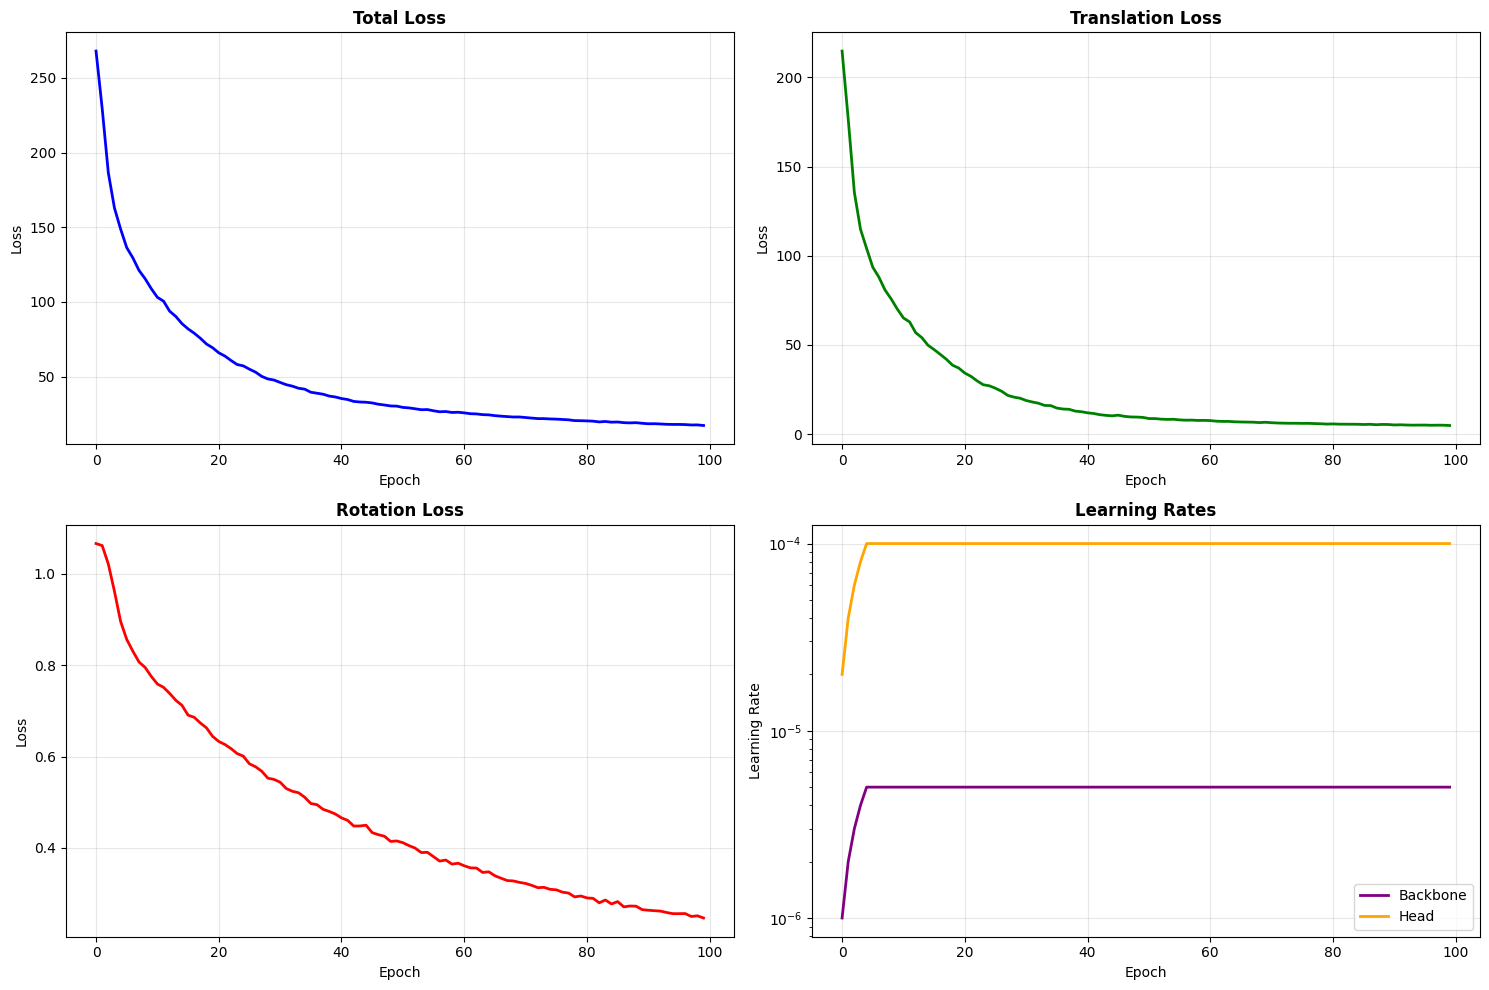

✅ Visualizzazione completata!

💡 Nota: Grafico LR mostra l'adattamento dinamico del learning rate


In [6]:
# Visualizza training curves con learning rates
print("📈 Visualizzazione training curves\n")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Total loss
axes[0, 0].plot(history['train_loss'], 'b-', linewidth=2)
axes[0, 0].set_title('Total Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(True, alpha=0.3)

# Translation loss
axes[0, 1].plot(history['train_trans'], 'g-', linewidth=2)
axes[0, 1].set_title('Translation Loss', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].grid(True, alpha=0.3)

# Rotation loss
axes[1, 0].plot(history['train_rot'], 'r-', linewidth=2)
axes[1, 0].set_title('Rotation Loss', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].grid(True, alpha=0.3)

# Learning rates
if 'lr_backbone' in history and 'lr_head' in history:
    axes[1, 1].plot(history['lr_backbone'], 'purple', linewidth=2, label='Backbone')
    axes[1, 1].plot(history['lr_head'], 'orange', linewidth=2, label='Head')
    axes[1, 1].set_title('Learning Rates', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].set_yscale('log')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Visualizzazione completata!")
print(f"\n💡 Nota: Grafico LR mostra l'adattamento dinamico del learning rate")

### Carica Modello Trained

Carica il checkpoint salvato e testa su sample del test set.

In [7]:
# Carica il modello trained
try:
    LOAD_EXPERIMENT = EXPERIMENT_NAME
except NameError:
    LOAD_EXPERIMENT = "pose_stable_train30"

checkpoint_dir = project_root / 'checkpoints' / 'pose' / LOAD_EXPERIMENT
checkpoint_path = checkpoint_dir / 'weights' / 'best.pt'

# Fallback ad altri esperimenti
if not checkpoint_path.exists():
    LOAD_EXPERIMENT = "pose_stable_train70"
    checkpoint_dir = project_root / 'checkpoints' / 'pose' / LOAD_EXPERIMENT
    checkpoint_path = checkpoint_dir / 'weights' / 'best.pt'
    print(f"⚠️  Fase 1 non trovata, carico esperimento: {LOAD_EXPERIMENT}\n")

# Fallback al vecchio path se non esiste
if not checkpoint_path.exists():
    checkpoint_path = project_root / 'checkpoints' / 'pose_best_quick.pth'
    print(f"⚠️  Nuovo path non trovato, uso vecchio checkpoint: {checkpoint_path.name}\n")

if checkpoint_path.exists():
    print(f"✅ Carico checkpoint: {checkpoint_path.relative_to(project_root)}\n")
    
    # Inizializza modello se non già fatto
    if 'model' not in locals():
        model = PoseEstimator(
            pretrained=True,
            dropout=Config.POSE_DROPOUT,
            freeze_backbone=False  # ✅ Coerente con Fase 1
        ).to(Config.DEVICE)
    
    # Carica weights
    checkpoint = torch.load(checkpoint_path, map_location=Config.DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"📊 Checkpoint info:")
    print(f"   Epoch: {checkpoint['epoch'] + 1}")
    print(f"   Loss: {checkpoint['loss']:.4f}")
    if 'loss_trans' in checkpoint:
        print(f"   Trans Loss: {checkpoint['loss_trans']:.4f}")
        print(f"   Rot Loss: {checkpoint['loss_rot']:.2f}")
    if 'config' in checkpoint:
        print(f"\n📋 Training config:")
        for key, value in checkpoint['config'].items():
            print(f"      {key}: {value}")
    print(f"\n   Device: {Config.DEVICE}")
    print(f"\n✅ Modello caricato e in modalità eval!")
    
else:
    print(f"❌ Checkpoint non trovato: {checkpoint_path}")
    print(f"   Path cercati:")
    print(f"   1. {checkpoint_dir / 'weights' / 'best.pt'}")
    print(f"   2. {project_root / 'checkpoints' / 'pose_best_quick.pth'}")
    print(f"\n   Esegui prima il training Fase 1 (cella 9)")
    print(f"   Oppure cambia LOAD_EXPERIMENT con un esperimento esistente")

✅ Carico checkpoint: checkpoints/pose/pose_stable_train100/weights/best.pt

📊 Checkpoint info:
   Epoch: 100
   Loss: 17.1820
   Trans Loss: 4.8458
   Rot Loss: 0.25

📋 Training config:
      phase: Phase 1 - Optimized
      epochs: 100
      warmup_epochs: 5
      lr_backbone: 5e-06
      lr_head: 0.0001
      batch_size: 64
      accumulation_steps: 2
      effective_batch_size: 128
      use_amp: False
      lambda_trans: 1.0
      lambda_rot: 50.0
      dropout: 0.5
      freeze_backbone: False
      scheduler: ReduceLROnPlateau
      device: mps
      image_size: 224
      crop_margin: 0.15

   Device: mps

✅ Modello caricato e in modalità eval!


### Test su Sample del Test Set

Visualizza predizioni vs ground truth su batch del test set.

🔍 Test su sample casuali del test set...

🎲 Batch casuale selezionato: 191/332



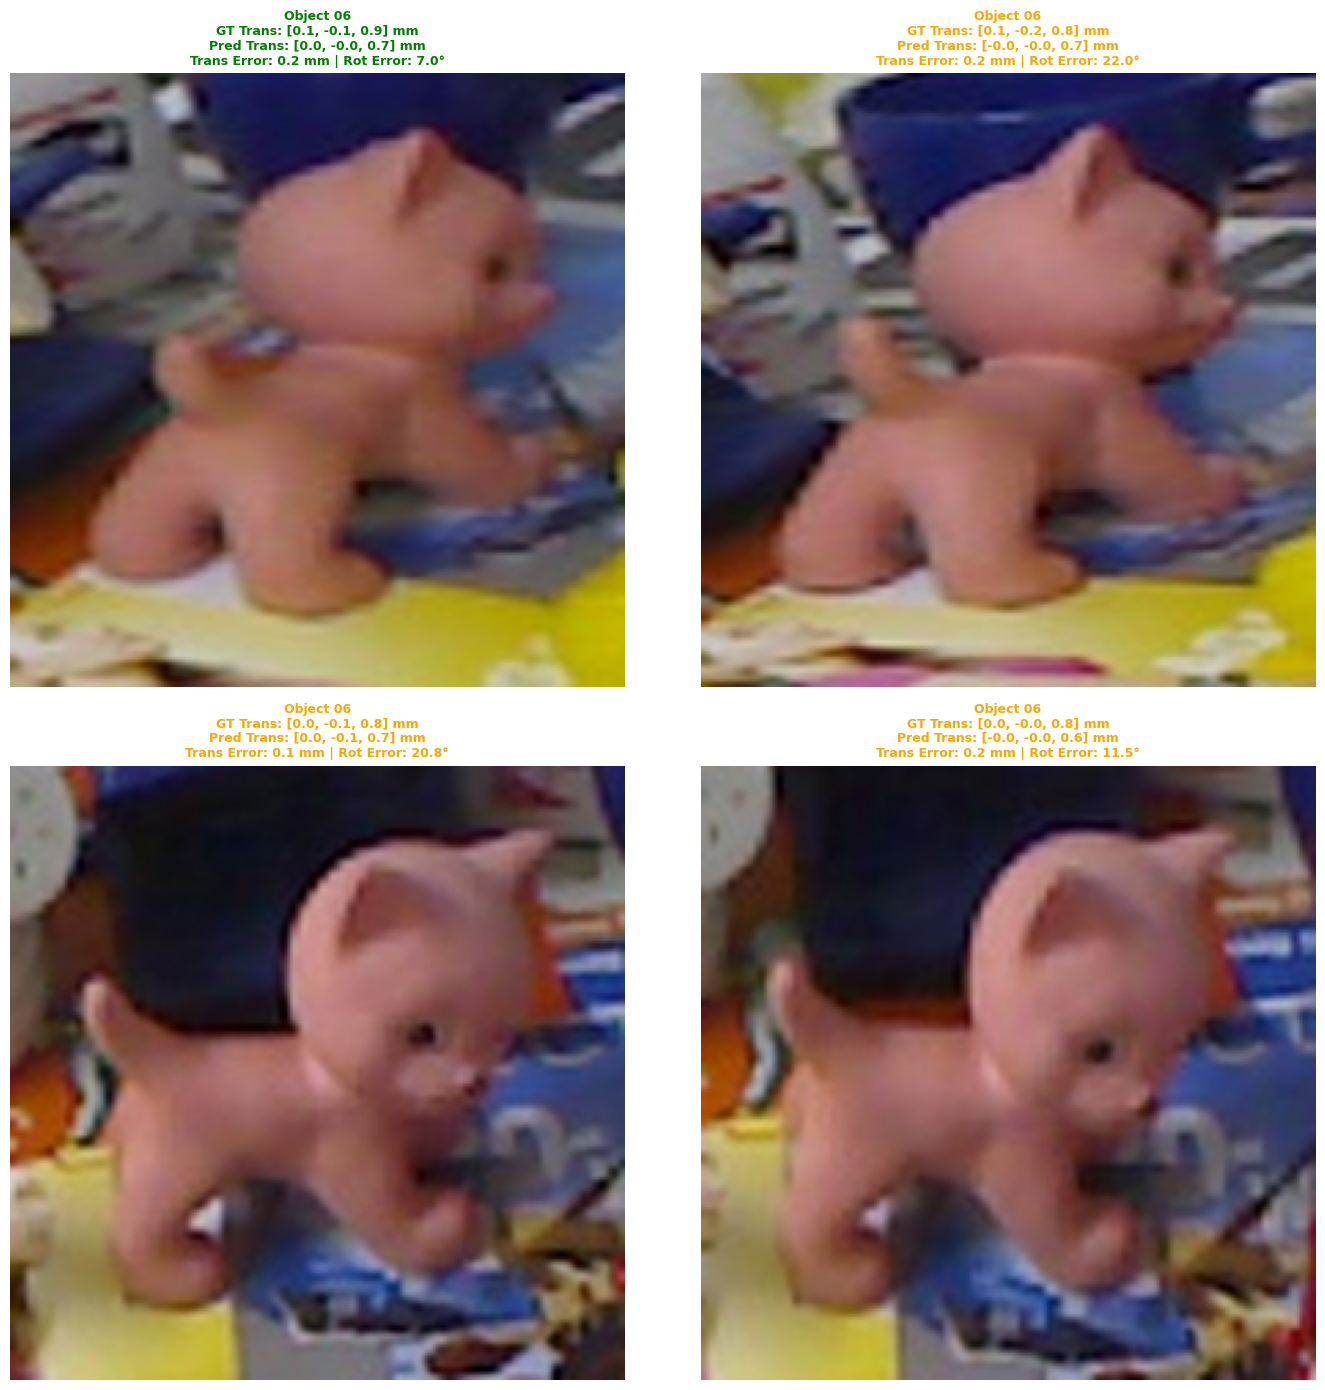

✅ Test completato su 64 sample

📊 Errori medi sul batch:
   Translation error: 0.15 ± 0.05 mm
   Rotation error: 21.71 ± 16.59°

💡 Interpretazione colori:
   🟢 Verde: Trans < 50mm e Rot < 10°
   🟠 Arancione: 50mm < Trans < 100mm
   🔴 Rosso: Trans > 100mm o Rot > 10°

🎲 Esegui di nuovo la cella per vedere altri sample casuali!


In [8]:
# Test su batch casuale del test set
import random

if 'model' in locals() and checkpoint_path.exists():
    print("🔍 Test su sample casuali del test set...\n")
    
    # ✅ Seleziona un batch casuale invece del primo
    random_batch_idx = random.randint(0, len(test_loader) - 1)
    for idx, batch in enumerate(test_loader):
        if idx == random_batch_idx:
            test_batch = batch
            break
    
    print(f"🎲 Batch casuale selezionato: {random_batch_idx + 1}/{len(test_loader)}\n")
    
    images = test_batch['rgb_crop'].to(Config.DEVICE)
    gt_quaternions = test_batch['quaternion'].to(Config.DEVICE)
    gt_translations = test_batch['translation'].to(Config.DEVICE)
    obj_ids = test_batch['obj_id']
    
    # Predizione
    with torch.no_grad():
        pred_quaternions, pred_translations = model(images)
    
    # Calcola errori
    trans_errors = torch.norm(pred_translations - gt_translations, dim=1).cpu().numpy()
    
    # Calcola rotation error (geodesic distance)
    dot_products = torch.sum(pred_quaternions * gt_quaternions, dim=1)
    dot_products = torch.clamp(torch.abs(dot_products), 0, 1)
    rot_errors = 2 * torch.acos(dot_products) * 180 / np.pi  # In gradi
    rot_errors = rot_errors.cpu().numpy()
    
    # Visualizza 4 sample
    fig, axes = plt.subplots(2, 2, figsize=(14, 14))
    axes = axes.flatten()
    
    for i in range(min(4, len(images))):
        # Denormalizza immagine
        img = images[i].permute(1, 2, 0).cpu().numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = img * std + mean
        img = np.clip(img, 0, 1)
        
        # Ground truth e prediction
        gt_q = gt_quaternions[i].cpu().numpy()
        gt_t = gt_translations[i].cpu().numpy()
        pred_q = pred_quaternions[i].cpu().numpy()
        pred_t = pred_translations[i].cpu().numpy()
        obj_id = obj_ids[i].item()
        
        axes[i].imshow(img)
        title = (
            f"Object {obj_id:02d}\n"
            f"GT Trans: [{gt_t[0]:.1f}, {gt_t[1]:.1f}, {gt_t[2]:.1f}] mm\n"
            f"Pred Trans: [{pred_t[0]:.1f}, {pred_t[1]:.1f}, {pred_t[2]:.1f}] mm\n"
            f"Trans Error: {trans_errors[i]:.1f} mm | Rot Error: {rot_errors[i]:.1f}°"
        )
        
        # Colora in base all'errore
        color = 'green' if trans_errors[i] < 50 and rot_errors[i] < 10 else 'orange' if trans_errors[i] < 100 else 'red'
        axes[i].set_title(title, fontsize=9, color=color, fontweight='bold')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Test completato su {len(images)} sample")
    print(f"\n📊 Errori medi sul batch:")
    print(f"   Translation error: {trans_errors.mean():.2f} ± {trans_errors.std():.2f} mm")
    print(f"   Rotation error: {rot_errors.mean():.2f} ± {rot_errors.std():.2f}°")
    print(f"\n💡 Interpretazione colori:")
    print(f"   🟢 Verde: Trans < 50mm e Rot < 10°")
    print(f"   🟠 Arancione: 50mm < Trans < 100mm")
    print(f"   🔴 Rosso: Trans > 100mm o Rot > 10°")
    print(f"\n🎲 Esegui di nuovo la cella per vedere altri sample casuali!")
    
else:
    print("❌ Carica prima il modello (cella precedente)")


### Valutazione Completa con ADD Metric

Valutazione su tutto il test set con metrica ADD (Average Distance of Model Points).
ADD < 10% del diametro dell'oggetto è considerato corretto.

In [9]:
# Carica modelli 3D (.ply) e models_info
print("📦 Caricamento modelli 3D per ADD metric...\n")

models_dict = load_all_models(Config.MODELS_PATH)
models_info = load_models_info(Config.MODELS_INFO_PATH)

print(f"✅ Caricati {len(models_dict)} modelli 3D:")
for obj_id, points in models_dict.items():
    diameter = models_info[obj_id]['diameter']
    print(f"   Object {obj_id:02d}: {len(points):,} punti, diametro {diameter:.1f} mm")

print(f"\n📊 ADD threshold: {Config.ADD_THRESHOLD * 100:.0f}% del diametro")
print(f"   Esempio: se diametro = 100mm, threshold = 10mm")

📦 Caricamento modelli 3D per ADD metric...

✅ Loaded model 01: 5841 points
✅ Loaded model 02: 38325 points
✅ Loaded model 03: 40759 points
✅ Loaded model 04: 18995 points
✅ Loaded model 05: 22831 points
✅ Loaded model 06: 15736 points
✅ Loaded model 07: 16573 points
✅ Loaded model 08: 12655 points
✅ Loaded model 09: 7912 points
✅ Loaded model 10: 18473 points
✅ Loaded model 11: 7479 points
✅ Loaded model 12: 15972 points
✅ Loaded model 13: 18216 points
✅ Loaded model 14: 27435 points
✅ Loaded model 15: 16559 points
✅ Caricati 15 modelli 3D:
   Object 01: 5,841 punti, diametro 102.1 mm
   Object 02: 38,325 punti, diametro 247.5 mm
   Object 03: 40,759 punti, diametro 167.4 mm
   Object 04: 18,995 punti, diametro 172.5 mm
   Object 05: 22,831 punti, diametro 201.4 mm
   Object 06: 15,736 punti, diametro 154.5 mm
   Object 07: 16,573 punti, diametro 124.3 mm
   Object 08: 12,655 punti, diametro 261.5 mm
   Object 09: 7,912 punti, diametro 109.0 mm
   Object 10: 18,473 punti, diametro 164.

In [10]:
# Valutazione completa con ADD metric
if 'model' in locals() and checkpoint_path.exists() and 'models_dict' in locals():
    print("🔍 Valutazione completa su test set con ADD metric...\n")
    print(f"⏳ Questo richiederà alcuni minuti...\n")
    
    model.eval()
    
    # Dizionari per raccogliere risultati per oggetto
    per_object_adds = {obj_id: [] for obj_id in Config.LINEMOD_OBJECTS}
    per_object_correct = {obj_id: 0 for obj_id in Config.LINEMOD_OBJECTS}
    per_object_total = {obj_id: 0 for obj_id in Config.LINEMOD_OBJECTS}
    
    all_adds = []
    
    # ✅ VALUTAZIONE COMPLETA - rimosso MAX_SAMPLES limit
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            # Move to device
            images = batch['rgb_crop'].to(Config.DEVICE)
            gt_quaternions = batch['quaternion'].to(Config.DEVICE)
            gt_translations = batch['translation'].to(Config.DEVICE)
            obj_ids = batch['obj_id'].cpu().numpy()
            
            # Predizione
            pred_quaternions, pred_translations = model(images)
            
            # ✅ VETTORIZZATO: Converti batch di quaternion in batch di rotation matrices (10x speedup!)
            from utils.transforms import quaternion_to_rotation_matrix_batch
            
            pred_R = quaternion_to_rotation_matrix_batch(pred_quaternions).cpu().numpy()
            gt_R = quaternion_to_rotation_matrix_batch(gt_quaternions).cpu().numpy()
            
            pred_t = pred_translations.cpu().numpy()
            gt_t = gt_translations.cpu().numpy()
            
            # Calcola ADD per ogni sample nel batch (ritorna un dizionario)
            result = compute_add_batch(
                pred_R, pred_t, gt_R, gt_t,
                obj_ids, models_dict, models_info,
                threshold=Config.ADD_THRESHOLD,
                symmetric_objects=Config.SYMMETRIC_OBJECTS
            )
            
            # Estrai i valori dal dizionario
            adds = result['add_values']
            corrects = result['is_correct']
            
            # Accumula risultati per oggetto
            for i, obj_id in enumerate(obj_ids):
                per_object_adds[obj_id].append(adds[i])
                per_object_total[obj_id] += 1
                if corrects[i]:
                    per_object_correct[obj_id] += 1
                all_adds.append(adds[i])
    
    # Calcola statistiche globali
    mean_add = np.mean(all_adds)
    median_add = np.median(all_adds)
    std_add = np.std(all_adds)
    total_correct = sum(per_object_correct.values())
    total_samples = sum(per_object_total.values())
    overall_accuracy = total_correct / total_samples if total_samples > 0 else 0
    
    # Calcola accuracy per oggetto
    per_object_accuracy = {}
    for obj_id in Config.LINEMOD_OBJECTS:
        if per_object_total[obj_id] > 0:
            per_object_accuracy[obj_id] = per_object_correct[obj_id] / per_object_total[obj_id]
        else:
            per_object_accuracy[obj_id] = 0
    
    # Stampa risultati
    print(f"\n{'='*80}")
    print(f"📈 RISULTATI VALUTAZIONE - ADD METRIC @ {Config.ADD_THRESHOLD * 100:.0f}% THRESHOLD")
    print(f"{'='*80}\n")
    
    print(f"🎯 Metriche Globali:")
    print(f"   Mean ADD: {mean_add:.2f} mm")
    print(f"   Median ADD: {median_add:.2f} mm")
    print(f"   Std ADD: {std_add:.2f} mm")
    print(f"   Overall Accuracy: {overall_accuracy * 100:.2f}%")
    print(f"   Correct: {total_correct} / {total_samples}")
    
    print(f"\n📋 Accuracy per Oggetto:")
    print(f"   {'Obj ID':<8} {'Accuracy':<12} {'Correct/Total':<15} {'Mean ADD (mm)':<15}")
    print(f"   {'-'*60}")
    
    for obj_id in sorted(Config.LINEMOD_OBJECTS):
        if per_object_total[obj_id] > 0:
            acc = per_object_accuracy[obj_id]
            mean_obj_add = np.mean(per_object_adds[obj_id])
            print(f"   {obj_id:<8} {acc*100:>6.2f}%      {per_object_correct[obj_id]:>4}/{per_object_total[obj_id]:<8}  {mean_obj_add:>12.2f}")
    
    # Interpretazione
    print(f"\n💡 Interpretazione:")
    if overall_accuracy > 0.7:
        print(f"   ✅ Ottimo! Accuracy > 70% indica pose estimation accurate")
    elif overall_accuracy > 0.5:
        print(f"   ✓  Buono! Accuracy > 50% indica pose discrete")
    elif overall_accuracy > 0.3:
        print(f"   ⚠️  Discreto. Accuracy > 30% ma potrebbe migliorare con più training")
    else:
        print(f"   ❌ Basso. Considerare 50 epoche con backbone unfrozen")
    
    print(f"\n✅ Valutazione completata su TUTTO il test set!")
    print(f"   Metriche accurate basate su {total_samples} sample totali")
    
else:
    print("❌ Carica prima il modello e i modelli 3D (celle precedenti)")

🔍 Valutazione completa su test set con ADD metric...

⏳ Questo richiederà alcuni minuti...



Evaluating:   8%|▊         | 28/332 [00:30<08:08,  1.61s/it]

Evaluating:  43%|████▎     | 144/332 [03:43<05:10,  1.65s/it]

Evaluating:  45%|████▍     | 148/332 [03:50<05:13,  1.70s/it]

Evaluating: 100%|██████████| 332/332 [08:14<00:00,  1.49s/it]


📈 RISULTATI VALUTAZIONE - ADD METRIC @ 10% THRESHOLD

🎯 Metriche Globali:
   Mean ADD: 22.35 mm
   Median ADD: 17.39 mm
   Std ADD: 17.06 mm
   Overall Accuracy: 49.67%
   Correct: 10538 / 21218

📋 Accuracy per Oggetto:
   Obj ID   Accuracy     Correct/Total   Mean ADD (mm)  
   ------------------------------------------------------------
   1         43.85%       895/2041             13.39
   2         41.71%       430/1031             35.42
   4         35.00%       357/1020             27.41
   5         44.63%       911/2041             27.98
   6         57.09%      1148/2011             17.28
   8         97.30%      1985/2040             12.97
   9         29.12%       592/2033             19.03
   10        40.37%       832/2061             24.71
   11        59.26%      1066/1799             18.28
   12        32.85%       683/2079             25.11
   13        59.86%       586/979              29.14
   14        58.64%       611/1042             29.26
   15        42.46%   

📊 Visualizzazione risultati ADD metric



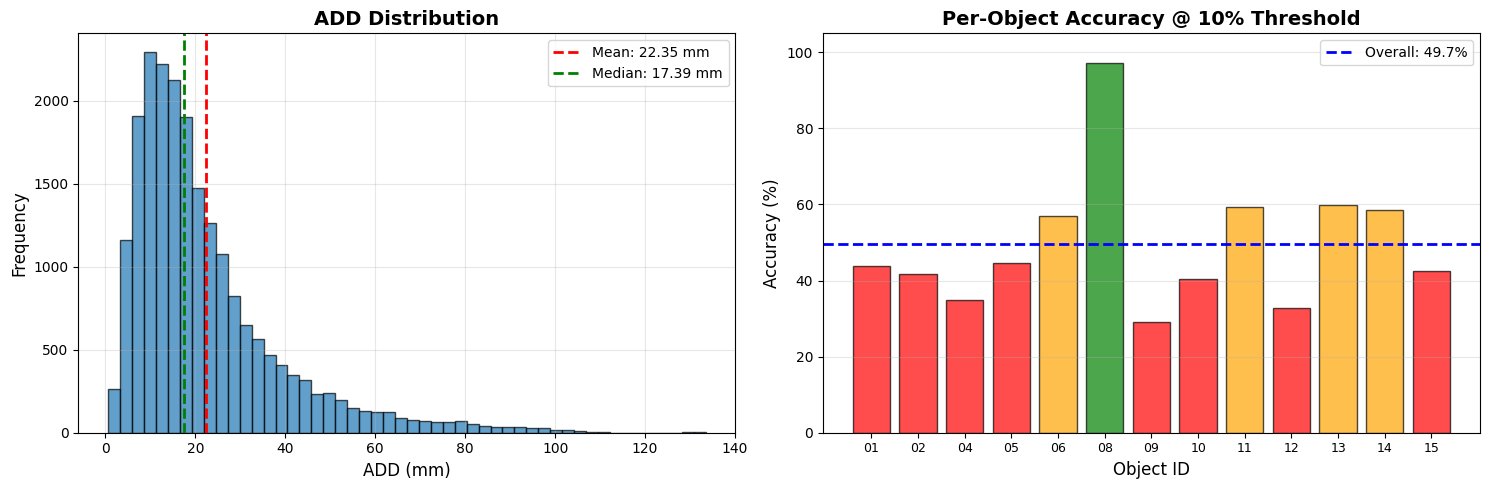

✅ Visualizzazione completata!

💡 Interpretazione colori (Accuracy bar chart):
   🟢 Verde: Accuracy > 70%
   🟠 Arancione: 50% < Accuracy < 70%
   🔴 Rosso: Accuracy < 50%


In [11]:
# Visualizza distribuzione ADD e accuracy per oggetto
if 'all_adds' in locals() and 'per_object_accuracy' in locals():
    print("📊 Visualizzazione risultati ADD metric\n")
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # ADD distribution histogram
    axes[0].hist(all_adds, bins=50, edgecolor='black', alpha=0.7)
    axes[0].axvline(mean_add, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_add:.2f} mm')
    axes[0].axvline(median_add, color='green', linestyle='--', linewidth=2, label=f'Median: {median_add:.2f} mm')
    axes[0].set_xlabel('ADD (mm)', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_title('ADD Distribution', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Per-object accuracy bar chart
    obj_ids = sorted(Config.LINEMOD_OBJECTS)
    accuracies = [per_object_accuracy[obj_id] * 100 for obj_id in obj_ids]
    colors = ['green' if acc > 70 else 'orange' if acc > 50 else 'red' for acc in accuracies]
    
    bars = axes[1].bar(range(len(obj_ids)), accuracies, color=colors, edgecolor='black', alpha=0.7)
    axes[1].axhline(overall_accuracy * 100, color='blue', linestyle='--', linewidth=2, label=f'Overall: {overall_accuracy*100:.1f}%')
    axes[1].set_xlabel('Object ID', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title(f'Per-Object Accuracy @ {Config.ADD_THRESHOLD*100:.0f}% Threshold', fontsize=14, fontweight='bold')
    axes[1].set_xticks(range(len(obj_ids)))
    axes[1].set_xticklabels([f'{obj_id:02d}' for obj_id in obj_ids], fontsize=9)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')
    axes[1].set_ylim([0, 105])
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Visualizzazione completata!")
    print(f"\n💡 Interpretazione colori (Accuracy bar chart):")
    print(f"   🟢 Verde: Accuracy > 70%")
    print(f"   🟠 Arancione: 50% < Accuracy < 70%")
    print(f"   🔴 Rosso: Accuracy < 50%")
    
else:
    print("❌ Esegui prima la valutazione completa (cella precedente)")

---

In [12]:
# 📊 VISUALIZZA ESPERIMENTI DISPONIBILI

import pandas as pd

pose_checkpoint_dir = project_root / 'checkpoints' / 'pose'

if pose_checkpoint_dir.exists():
    experiments = [d for d in pose_checkpoint_dir.iterdir() if d.is_dir()]
    
    if experiments:
        print(f"📁 Esperimenti disponibili ({len(experiments)}):\n")
        
        for exp_dir in sorted(experiments):
            exp_name = exp_dir.name
            args_file = exp_dir / 'args.yaml'
            results_file = exp_dir / 'results.csv'
            best_weights = exp_dir / 'weights' / 'best.pt'
            
            print(f"{'='*80}")
            print(f"📌 {exp_name}")
            print(f"{'='*80}")
            
            # Leggi configurazione
            if args_file.exists():
                with open(args_file, 'r') as f:
                    config = yaml.safe_load(f)
                print(f"⚙️  Configurazione:")
                print(f"   Epoche: {config.get('epochs', 'N/A')}")
                print(f"   Learning rate: {config.get('lr', 'N/A')}")
                print(f"   Batch size: {config.get('batch_size', 'N/A')}")
                print(f"   Backbone frozen: {config.get('freeze_backbone', 'N/A')}")
            
            # Leggi risultati
            if results_file.exists():
                df = pd.read_csv(results_file)
                print(f"\n📈 Risultati:")
                print(f"   Epoche completate: {len(df)}")
                print(f"   Best loss: {df['train_loss'].min():.4f} (epoch {df['train_loss'].idxmin() + 1})")
                print(f"   Last loss: {df['train_loss'].iloc[-1]:.4f}")
                print(f"   Trans loss: {df['train_trans_loss'].iloc[-1]:.4f}")
                print(f"   Rot loss: {df['train_rot_loss'].iloc[-1]:.2f}")
            
            # Controlla weights
            if best_weights.exists():
                weight_size = best_weights.stat().st_size / (1024 * 1024)
                print(f"\n💾 Checkpoint:")
                print(f"   Best weights: ✅ ({weight_size:.1f} MB)")
            else:
                print(f"\n💾 Checkpoint:")
                print(f"   Best weights: ❌ Non trovato")
            
            print()
    else:
        print("❌ Nessun esperimento trovato in checkpoints/pose/")
        print("   Esegui prima il training (cella 9)")
else:
    print("❌ Directory checkpoints/pose/ non esiste")
    print("   Esegui prima il training (cella 9)")

📁 Esperimenti disponibili (2):

📌 pose_stable_train100
⚙️  Configurazione:
   Epoche: 100
   Learning rate: N/A
   Batch size: 64
   Backbone frozen: False

📈 Risultati:
   Epoche completate: 100
   Best loss: 17.1820 (epoch 100)
   Last loss: 17.1820
   Trans loss: 4.8458
   Rot loss: 0.25

💾 Checkpoint:
   Best weights: ✅ (299.5 MB)

📌 pose_stable_train30
⚙️  Configurazione:
   Epoche: 30
   Learning rate: N/A
   Batch size: 128
   Backbone frozen: False

📈 Risultati:
   Epoche completate: 30
   Best loss: 33.9162 (epoch 29)
   Last loss: 35.0701
   Trans loss: 28.1518
   Rot loss: 0.69

💾 Checkpoint:
   Best weights: ✅ (299.5 MB)

